# 实现卷积层的前向传播与反向传播
---
- 预备知识：
   1. 矩阵向量偏导计算
   2. CNN 前向传播细节

- 参考：
> [知乎【反向传播之六：CNN卷积层反向传播】](https://zhuanlan.zhihu.com/p/40951745?utm_source=qq&utm_medium=social&utm_oi=775799432212918272)

首先，实现前向传播

X conv K = Y


size analysis：
    [w,h] conv [k,k]  -> [w-k+1,h-k+1]

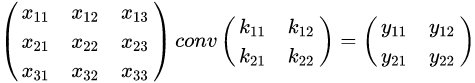

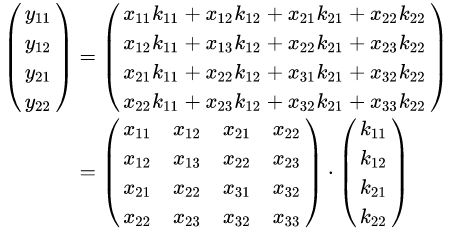

> 实现时不是多层for循环嵌套逐元素计算，而是先将原始矩阵做转换然后再做矩阵乘法操作，同时计算出Y的每一个元素，最后进行维度整理(这样减少了O(w*h)次逐元素乘法与sum)

### im2col
---
将feature map转化为col-matrix 每一行都是X的在K的尺寸下的窗口值做flatten

```
#这是一个非常朴素的实现，优点是简单易懂，缺点是性能，可以慢到你想哭，后面再谈谈优化算法
def im2col(image, ksize, stride):
    # image is a 4d tensor([batchsize, width ,height, channel])
    image_col = []
    for i in range(0, image.shape[1] - ksize + 1, stride):
        for j in range(0, image.shape[2] - ksize + 1, stride):
            col = image[:, i:i + ksize, j:j + ksize, :].reshape([-1])
            image_col.append(col)
    image_col = np.array(image_col)

    return image_col

```


---
##### 改进方法参考


### 前向传播具体步骤

1. 将矩阵X使用im2col函数转换成X` X`=im2col(X)
2. 对卷积核K进行reshape处理（K`=K.reshape([-1])）
3. 矩阵乘法 Y`=X`·K`
4. 将Y`做reshape由向量变为矩阵

##### 注意：
1. 上述算法实际上是单通道的情况，通常还有batch channel维度
2. 实际上的卷积操作还有偏置 sum(k_i*x_i)+b  for i in all_channels

---

### 反向传播

需要计算的梯度（given $\nabla Y$）
   1. $\nabla X$
   2. $\nabla K$
   3. $\nabla B$  （$\nabla Y$）

#### a. 计算$\nabla K$

实际上就是计算$\frac{d Y}{d K}$

步骤：
1. $\nabla Y`= \nabla Y.reshape([-1])$
2. $\frac{\sigma L}{\sigma K`} = X`_{}^{T} \cdot \nabla Y`$
3. $\nabla K = \nabla K`.reshape([k,k])$


#### b. 计算$\nabla X$

实际上计算$\frac{d Y}{d X}$

矩阵对向量求偏导，根据公式有




这里求得的是$ \nabla im2col(X) $，但是由col转换为im（im2col的逆映射）的开销非常大；因此，思考其他方法计算L对X的偏导



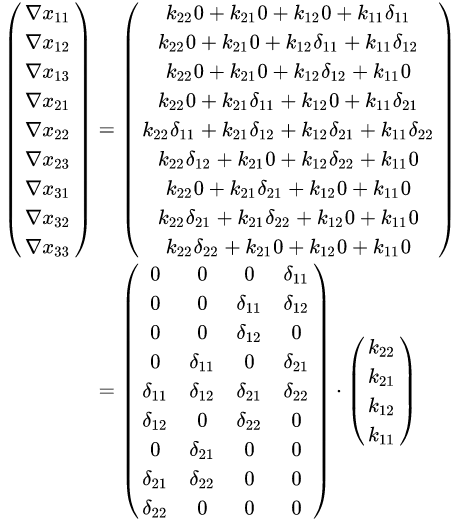

根据上面的公式可以看出，存在如下关系

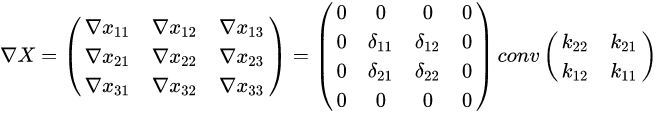

因此，对X的偏导可以表示为conv(pad($\delta Y$),rot(K,pi))

> pad $\delta Y$ 表示对$\delta Y$进行外填充

> rot(K,pi) 对卷积核K旋转180度

How to rotate?

```

#self.weights维度为（k，k，self.input_channels， self.output_channels）       
#方法一
        # flip_weights = np.flipud(np.fliplr(self.weights))
        # flip_weights = flip_weights.swapaxes(2, 3)

#方法二
        flip_weights=self.weights.reshape([-1,self.input_channels,self.output_channels])
        flip_weights=flip_weights[::-1,...]
        flip_weights = flip_weights.swapaxes(1, 2)
        
#以下相同
        col_flip_weights = flip_weights.reshape([-1, self.input_channels])

```

对于im2col的改进：

1. winograd算法  [参考](https://www.cnblogs.com/shine-lee/p/10906535.html)
2. 使用numpy的as_strided函数实现im2col
3. CUDA